### Mounting


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data Preprocessing


In [ ]:
import os

In [ ]:
import numpy as np

In [ ]:
FLDR="drive/MyDrive/RSNA_Dataset/"

In [ ]:
files=os.listdir(FLDR)

In [ ]:
files

['stage_2_train_labels.csv', 'stage_2_train_images.zip', 'extracted']

In [ ]:
train_zip=file[1]

In [ ]:
import zipfile

In [ ]:
archive=zipfile.ZipFile(FLDR+train_zip)

In [ ]:
archive.extractall(FLDR+"extracted")

In [ ]:
import pandas as pd

In [ ]:
df_meta=pd.read_csv(FLDR+files[0])

In [ ]:
df_meta.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
df_meta=df_meta.drop(['x','y','width','height'],axis=1)

In [ ]:
df_meta.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [ ]:
def replace(x):
  return x+".dcm"

In [ ]:
def replace_target(x):
  if x==0:
    return "NORMAL"
  else:
    return "PNEUMONIA"

In [ ]:
df_meta["patientId"]=df_meta["patientId"].apply(replace)

In [ ]:
df_meta.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,0
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,0
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,1


In [ ]:
df_meta["Target"]=df_meta["Target"].apply(replace_target)

In [ ]:
df_meta.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,NORMAL
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,NORMAL
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,NORMAL
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,NORMAL
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,PNEUMONIA


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train,test=train_test_split(df_meta,test_size=0.25)
train,val=train_test_split(train,test_size=0.15)

### Data Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip3 install pydicom

In [ ]:
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

# tested on tf 2.1 

class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']
        self.directory= kwargs['directory']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(self.directory+dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array((self.y.iloc[indices_array]).apply(lambda x: 0 if x=="NORMAL" else 1).astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array

In [ ]:
train_set=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True, 
    vertical_flip=True,
)

In [ ]:
val_set=ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = DCMDataFrameIterator(dataframe=train,
                                       directory=FLDR+'extracted/',
                                       x_col='patientId',
                                       y_col='Target',
                                       image_data_generator=train_set,
                                       target_size=(224,224),
                                       class_mode= "binary",
                                       color_mode= 'grayscale',
                                       batch_size=32
                                       )

Found 19269 validated image filenames belonging to 2 classes.


In [ ]:
val_generator = DCMDataFrameIterator(dataframe=val,
                                       directory=FLDR+'extracted/',
                                       x_col='patientId',
                                       y_col='Target',
                                       image_data_generator=val_set,
                                       target_size=(224,224),
                                       class_mode= "binary",
                                       color_mode= 'grayscale',
                                       batch_size=32
                                       )

Found 3401 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = DCMDataFrameIterator(dataframe=test,
                                       directory=FLDR+'extracted/',
                                       x_col='patientId',
                                       y_col='Target',
                                       image_data_generator=val_set,
                                       target_size=(224,224),
                                       class_mode= "binary",
                                       color_mode= 'grayscale',
                                       batch_size=32
                                       )

Found 7557 validated image filenames belonging to 2 classes.


### Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Add, Lambda, BatchNormalization
from tensorflow.keras.layers import multiply, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Input, Activation,Flatten

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
def channel_attention(input,ratio=16):
  
  channel = input.shape[-1]       ### Channels on last axis
  
  ### Average
  avg_pool= GlobalAveragePooling2D()(input)  
  avg_pool= Reshape((1,1,channel))(avg_pool)
  dense_shared_1_avg= Dense(channel,activation='relu',kernel_initializer='he_normal')(avg_pool)
  bottleneck_avg= Dense(channel//ratio,activation='relu',kernel_initializer='he_normal')(dense_shared_1_avg)
  dense_shared_2_avg= Dense(channel,activation='relu',kernel_initializer='he_normal')(bottleneck_avg)

  ### Max
  max_pool= GlobalMaxPooling2D()(input)  
  max_pool= Reshape((1,1,channel))(max_pool)
  dense_shared_1_max= Dense(channel,activation='relu',kernel_initializer='he_normal')(max_pool)
  bottleneck_max= Dense(channel//ratio,activation='relu',kernel_initializer='he_normal')(dense_shared_1_max)
  dense_shared_2_max= Dense(channel,activation='relu',kernel_initializer='he_normal')(bottleneck_max)

  ### Add
  channel_comb=Add()([dense_shared_2_avg,dense_shared_2_max])
  channel_comb_sigmoid=Activation("sigmoid")(channel_comb)

  ### Multiplication
  channel_return=multiply([channel_comb_sigmoid,input])

  return channel_return


In [ ]:
def spatial_attention(input):
  ### Channels on last considered
  
  ### Average pooling on channels
  avg_pool_channel=Lambda(lambda x: K.mean(x,axis=3,keepdims=True))(input)

  ### Max pooling on channels
  max_pool_channel=Lambda(lambda x: K.mean(x,axis=3,keepdims=True))(input)

  ### Concat 
  concat=Concatenate(axis=3)([avg_pool_channel,max_pool_channel])

  ### Dense
  kernel_size=7
  conv_concat=Conv2D(filters=1, kernel_size=kernel_size, strides=1,padding='same',activation='sigmoid',kernel_initializer='he_normal')(concat)

  spatial_return=multiply([conv_concat,input])

  return spatial_return


In [ ]:
def cbam(input,ratio=16):
  
  ### Channel attention followed by Spatial attention

  cbam= channel_attention(input, ratio)
  cbam= spatial_attention(cbam)

  return cbam

In [ ]:
def Res_CBAM_module(input,features):

  conv_1=Conv2D(filters=features, kernel_size=3, strides=1,padding='same',kernel_regularizer=l2(0.001))(input)
  conv_1=BatchNormalization()(conv_1)
  conv_1=Activation("relu")

  conv_2=Conv2D(filters=features,kernel_size=3,strides=1,padding="same",kernel_regularizer=l2(0.001))(conv_1)
  conv_2=BatchNormalization()(conv_2)

  conv_cbam=cbam(conv_2,16)

  Res_cbam_ret=Add()([conv_cbam,conv_1])
  Res_cbam_ret=Activation("relu")(Res_cbam_ret)

  return Res_cbam_ret

In [ ]:
def pool_down(input):

  channel = input.shape[-1]     ### Channels last
  
  max_pool=MaxPooling2D(pool_size=2)(input)
  avg_pool=AveragePooling2D(pool_size=2)(input)

  concat=Concatenate()([max_pool,avg_pool])
  conv_concat=Conv2D(filters=channel, kernel_size=1, strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(concat)

  return conv_concat




In [ ]:
def ASPP(input):
  
  channel = input.shape[-1] 

  aspp_1= Conv2D(filters=channel, kernel_size=3, strides=1,dilation_rate=2,padding='same',activation='relu')(input)

  aspp_2= Conv2D(filters=channel, kernel_size=3, strides=1,dilation_rate=4,padding='same',activation='relu')(input)

  aspp_3= Conv2D(filters=channel, kernel_size=3, strides=1,dilation_rate=8,padding='same',activation='relu')(input)

  concat=Concatenate()([aspp_1,aspp_2,aspp_3])
  conv_concat=Conv2D(filters=channel, kernel_size=1, strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(concat)

  return conv_concat


In [ ]:
def get_model(input_shape):
  input_tensor=Input(input_shape)

  ## 1st block
  block_1= Res_CBAM_module(input_tensor, 64)

  ## 1st transition
  block_1= pool_down(block_1)

  ## 2nd block
  block_2= Res_CBAM_module(block_1, 128)

  ## 2nd transition
  block_2= pool_down(block_2)
  block_2= ASPP(block_2)

  ## 3rd block
  block_3= Res_CBAM_module(block_2, 128)

  ## 3rd transition
  block_3= pool_down(block_3)

  ## 4th block
  block_4= Res_CBAM_module(block_3, 256)

  ## 2nd transition
  block_4= pool_down(block_4)
  block_4= ASPP(block_4)

  ### Final
  Flattened=Flatten()(block_4)
  Dense_1=Dense(256, activation="relu")(Flattened)
  
  ### Output
  Output=Dense(1,activation="sigmoid")(Dense_1)

  model=Model(inputs=[input_tensor],outputs=[Output])

  model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])

  return model


In [ ]:
model=get_model((224,224,1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 224, 224, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 224, 224, 64) 256         conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 224, 224, 64) 36928       batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

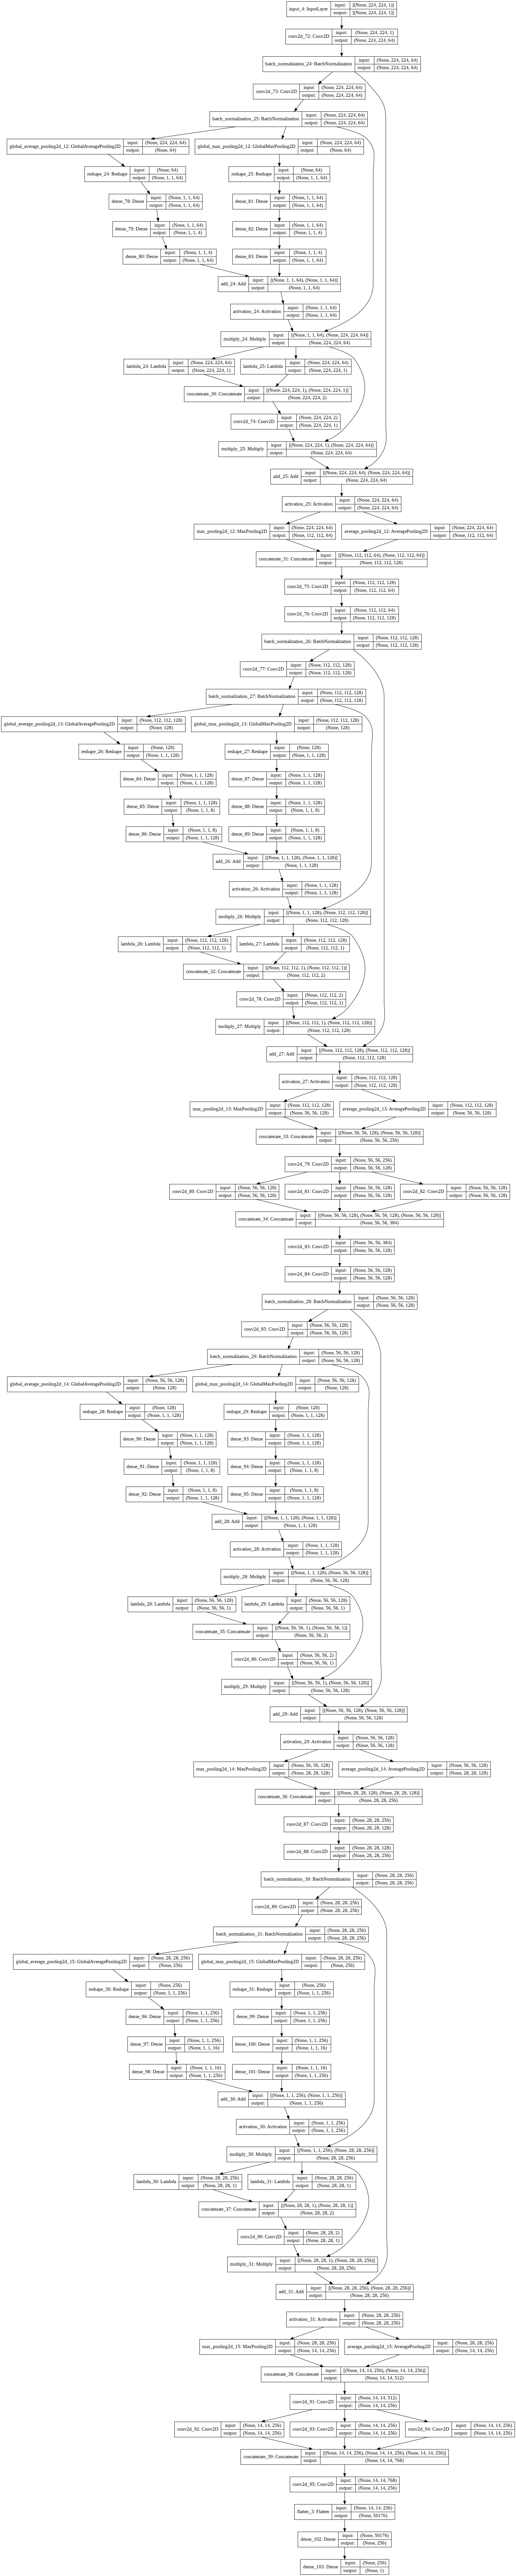

In [ ]:
plot_model(model, to_file=FLDR+"Plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(FLDR+"Model.h5", monitor='loss', save_best_only=True, mode='auto') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

### Training

In [ ]:
history = model.fit_generator(
	generator=train_generator,
	steps_per_epoch=20,
	epochs=30,
  callbacks=callbacks_list
  )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
20/20 [==============================] - 135s 7s/step - loss: 1.3828 - accuracy: 0.7453


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
20/20 [==============================] - 144s 7s/step - loss: 1.2921 - accuracy: 0.7234
Epoch 3/30
20/20 [==============================] - 134s 7s/step - loss: 1.2485 - accuracy: 0.7312
Epoch 4/30
20/20 [==============================] - 134s 7s/step - loss: 1.1582 - accuracy: 0.7484
Epoch 5/30
20/20 [==============================] - 126s 6s/step - loss: 1.1074 - accuracy: 0.7453
Epoch 6/30
20/20 [==============================] - 118s 6s/step - loss: 0.9958 - accuracy: 0.7609
Epoch 7/30
20/20 [==============================] - 116s 6s/step - loss: 0.9568 - accuracy: 0.7594
Epoch 8/30
20/20 [==============================] - 112s 6s/step - loss: 0.9624 - accuracy: 0.7391
Epoch 9/30
20/20 [==============================] - 110s 6s/step - loss: 0.8576 - accuracy: 0.7891
Epoch 10/30
20/20 [==============================] - 100s 5s/step - loss: 0.8382 - accuracy: 0.7922
Epoch 11/30
20/20 [==============================] - 99s 5s/step - loss: 0.8369 - accuracy: 0.7531
Epoch 12/

In [ ]:
import matplotlib.pyplot as plt


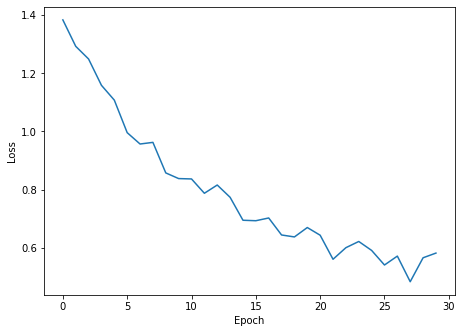

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()


In [ ]:
pred_test=model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
pred_n=np.round(pred_test)

In [ ]:
pred_n_1=pred_n.reshape((len(pred_n),))


In [ ]:
true_lab=test_generator.classes

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(true_lab,pred_n_1))

In [ ]:
print(confusion_matrix(true_lab,pred_n))